In [1]:
import sys
import os

# 현재 디렉토리의 상위 폴더 경로를 구합니다.
# matplotsoccer를 설치(pip)해서 라이브러리르 사용할 수 있지만, 본 연구에서는 좀 더 시각적으로 설명하기 위해 라이브러리를 조금 수정해보았다
parent_dir = os.path.dirname(os.getcwd())

# 상위 폴더 경로를 sys.path에 추가합니다.
sys.path.insert(0, parent_dir)

In [2]:
import os
import warnings
import tqdm
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [3]:
%load_ext autoreload
%autoreload 2
import socceraction.spadl as spadl
import socceraction.vaep.formula as vaepformula

/home/toc3/anaconda3/envs/py3_11/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [4]:
import matplotsoccer
import matplotlib.pyplot as plt

In [5]:
folder = 'binary-data'    
X_test = pd.read_csv(f'../data/{folder}/test/X_test.csv')
Y_test = pd.read_csv(f'../data/{folder}/test/Y_test.csv')

print(X_test.shape, Y_test.shape)

binary_catboost_probability = pd.read_csv('./result/binary_prediction.csv')
binary_catboost_probability

(82108, 161) (82108, 2)


,scores,concedes
0,0.001492,0.002138
1,0.002288,0.001162
2,0.003459,0.001147
3,0.002028,0.000996
4,0.004177,0.000921
...,...,...
82103,0.016488,0.000864
82104,0.001068,0.009131
82105,0.002919,0.003387
82106,0.002082,0.001599


#### 예측한 binary_catboost_probability를 경기별로 매칭시켜서 새로 저장

In [6]:
spadl_datafolder = "../data-fifa/La Liga/spadl-statsbomb/"
test_spadl_h5 = os.path.join(spadl_datafolder, "test_competitions.h5")

test_predictions_h5 = os.path.join("./result/binary_predictions.h5")

In [7]:
with pd.HDFStore(test_spadl_h5) as spadlstore:
    test_games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    players = spadlstore["players"]
    teams = spadlstore["teams"]

print("nb of games:", len(test_games))
test_games.head()

nb of games: 35


,game_id,season_id,competition_id,competition_stage,game_day,game_date,home_team_id,away_team_id,home_score,away_score,venue,referee,competition_name,country_name,competition_gender,season_name,home_team_name,away_team_name
0,3773386,90,11,Regular Season,8,2020-10-31 21:00:00,206,217,1,1,Estadio de Mendizorroza,NaN,La Liga,Spain,male,2020/2021,Deportivo Alavés,Barcelona
1,3773565,90,11,Regular Season,18,2021-01-09 18:30:00,1049,217,0,4,Estadio Nuevo Los Cármenes,Ricardo De Burgos Bengoetxea,La Liga,Spain,male,2020/2021,Granada,Barcelona
2,3773457,90,11,Regular Season,37,2021-05-16 18:30:00,217,209,1,2,Spotify Camp Nou,NaN,La Liga,Spain,male,2020/2021,Barcelona,Celta Vigo
3,3773631,90,11,Regular Season,22,2021-02-07 21:00:00,218,217,2,3,Estadio Benito Villamarín,NaN,La Liga,Spain,male,2020/2021,Real Betis,Barcelona
4,3773665,90,11,Regular Season,26,2021-03-06 21:00:00,422,217,0,2,Estadio El Sadar,Guillermo Cuadra Fernández,La Liga,Spain,male,2020/2021,Osasuna,Barcelona


In [8]:
# get rows with game id per action
A = []
for game_id in tqdm.tqdm(test_games.game_id, "Loading game ids"):
    Ai = pd.read_hdf(test_spadl_h5, f"actions/game_{game_id}")
    A.append(Ai[["game_id"]])
A = pd.concat(A)
A = A.reset_index(drop=True)

# concatenate action game id rows with predictions and save per game
grouped_predictions = pd.concat([A, binary_catboost_probability], axis=1).groupby("game_id")

with pd.HDFStore(test_predictions_h5) as predictionstore:
    for k, df in tqdm.tqdm(grouped_predictions, desc="Saving predictions per game"):
        df = df.reset_index(drop=True)
        predictionstore.put(f"game_{int(k)}", df[binary_catboost_probability.columns])

Loading game ids:   0%|          | 0/35 [00:00<?, ?it/s]

Saving predictions per game: 100%|██████████| 35/35 [00:00<00:00, 248.40it/s]


## Compute VAEP

- 주어진 binary_catboost_probability를 VAEP에 적용
- 득점, 실점 예측확률값 & 기존 이벤트 데이터(위치, 행동 유형, 행동결과)를 매칭

In [9]:
test_actions = []

for game in tqdm.tqdm(list(test_games.itertuples()), desc="Rating actions"): 
    actions = pd.read_hdf(test_spadl_h5, f"actions/game_{game.game_id}")
    actions = (
        spadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left")
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
    )
    preds = pd.read_hdf(test_predictions_h5, f"game_{game.game_id}")
    
    values = vaepformula.value(actions, preds.scores, preds.concedes)
    test_actions.append(pd.concat([actions, preds, values], axis=1))
    
test_actions = pd.concat(test_actions).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
test_actions.columns

Rating actions:   0%|          | 0/35 [00:00<?, ?it/s]

Rating actions: 100%|██████████| 35/35 [00:01<00:00, 34.86it/s]


Index(['game_id', 'original_event_id', 'period_id', 'time_seconds', 'team_id',
       'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'type_id',
       'result_id', 'bodypart_id', 'action_id', 'type_name', 'result_name',
       'bodypart_name', 'player_name', 'nickname', 'team_name', 'scores',
       'concedes', 'offensive_value', 'defensive_value', 'vaep_value'],
      dtype='object')

In [10]:
test_actions.head()

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,...,result_name,bodypart_name,player_name,nickname,team_name,scores,concedes,offensive_value,defensive_value,vaep_value
0,3764440,23743e50-fbe4-4929-938e-9b3ab39ff4ff,1,0.0,1042,12072.0,52.058824,33.655696,62.470588,42.435443,...,success,foot_left,Pere Milla Peña,Pere Milla,Elche,0.001205,0.002699,0.000000,-0.000000,0.000000
1,3764440,937db060-0bc2-45d9-9bf1-fd365840c580,1,1.0,1042,24517.0,62.470588,42.435443,61.676471,43.382278,...,success,foot,José Raúl Gutiérrez Parejo,Raúl Guti,Elche,0.002979,0.001364,0.001774,0.001334,0.003108
2,3764440,df248b0b-baeb-4bf0-9557-062682814138,1,1.0,1042,24517.0,61.676471,43.382278,76.411765,38.820253,...,success,foot_right,José Raúl Gutiérrez Parejo,Raúl Guti,Elche,0.002333,0.001404,-0.000646,-0.000040,-0.000685
3,3764440,3f30f412-a641-40c9-9a11-9716b039a566,1,3.0,1042,24169.0,76.411765,38.820253,75.617647,38.131646,...,success,foot,Gonzalo Cacicedo Verdú,Gonzalo Verdú,Elche,0.003141,0.001345,0.000808,0.000059,0.000867
4,3764440,934bd267-dcf8-4f0f-aa6b-ce68cbe9397d,1,4.0,1042,24169.0,75.617647,38.131646,74.911765,14.891139,...,success,foot_right,Gonzalo Cacicedo Verdú,Gonzalo Verdú,Elche,0.002343,0.000890,-0.000799,0.000455,-0.000343


## Analyse VAEP ratings
### Most valuable players

- VAEP를 통한 통계량 추정

- 선수 id별 team_name기록(한 시즌에 두팀에서 뛴 선수까지 고려)

In [11]:
player_team = dict()
for (id,team) in test_actions[['player_id', 'team_name']].values:
    if id in player_team.keys():
        #한 시즌에 두팀에서 뛴 경우 두 팀 모두 기록
        if team not in player_team[id]:
            player_team[id]+= f' / {team}'
    else:
        player_team[id] = team
player_team[24730.0]

'Celta Vigo / Real Valladolid'

### 모든 이벤트를 전부 고려했을 때, VAEP의 합은 어느 선수가 가장 높을까?

- 바르셀로나의 경기가 압도적으로 많기 때문에 나타나는 현상
- 경기를 뛴 시간를 고려하지 않음

In [12]:
test_actions["count"] = 1

# Compute each player's number of actions and total VAEP values
playersR = (
    test_actions[["player_id","vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)

# Add player names
playersR = playersR.merge(players[["player_id", "nickname", "player_name"]], how="left")
playersR["player_name"] = playersR[["nickname","player_name"]].apply(lambda x: x.iloc[0] if x.iloc[0] else x.iloc[1], axis=1)

# Show results
playersR = playersR[["player_id", "player_name","vaep_value", "offensive_value", "defensive_value", "count"]]
playersR['team_name'] = playersR['player_id'].apply(lambda id : player_team[id])

playersR.sort_values("vaep_value", ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,team_name
52,5503.0,Lionel Messi,33.766257,34.921154,-1.154897,5435,Barcelona
39,5203.0,Sergio Busquets,9.355383,9.237984,0.117399,4736,Barcelona
40,5211.0,Jordi Alba,8.690245,8.708164,-0.017919,5251,Barcelona
194,8118.0,Frenkie de Jong,5.140073,5.223971,-0.083898,5089,Barcelona
373,43728.0,Óscar Mingueza,4.954913,3.995411,0.959502,2927,Barcelona
163,6826.0,Clément Lenglet,4.091611,4.869310,-0.777699,4382,Barcelona
48,5477.0,Ousmane Dembélé,3.444977,3.835656,-0.390679,2120,Barcelona
347,30756.0,Ansu Fati,3.387756,3.490157,-0.102401,502,Barcelona
251,20055.0,Marc-André ter Stegen,2.291365,1.819844,0.471521,1761,Barcelona
293,24049.0,Luis Rioja,2.086417,2.073315,0.013102,77,Deportivo Alavés


- 바르셀로나의 경기수/이벤트 횟수가 굉장히 많음

In [14]:
test_actions['team_name'].value_counts()

team_name
Barcelona           52692
Sevilla              2281
Villarreal           2141
Atlético Madrid      2084
Athletic Club        1990
Real Madrid          1985
Celta Vigo           1829
Real Betis           1806
Real Sociedad        1758
Levante UD           1754
Huesca               1713
Real Valladolid      1684
Osasuna              1612
Valencia             1476
Deportivo Alavés     1209
Granada              1165
Getafe               1060
Cádiz                 974
Elche                 895
Name: count, dtype: int64

### 경기를 뛴 시간대비 어느 선수가 VAEP가 가장 높을까?

- 경기를 뛴 시간(minute)대비 얼마나 가치 있는(VAEP가 높은)플레이를 수행했는지 분석
- 그럼에도 불구하고 VAEP는 메시가 압도적

### 각 선수별 포지션 

1. Lionel Messi (Barcelona) - 공격수 또는 공격형 미드필더
2. Ansu Fati (Barcelona) - 공격수 또는 공격형 미드필더
3. Carlos Soler (Valencia) - 중앙 미드필더
4. Iker Muniain (Athletic Club) - 공격수 또는 공격형 미드필더
5. Maxi Gómez (Valencia) - 공격수
6. Gabriel Paulista (Valencia) - 수비수
7. Yannick Carrasco (Atlético Madrid) - 공격수 또는 공격형 미드필더
8. Sergio Busquets (Barcelona) - 중앙 미드필더 (수비형 미드필더)
9. Casemiro (Real Madrid) - 중앙 미드필더 (수비형 미드필더)
10. Unai Simón (Athletic Club) - 골키퍼

- 띈 시간 대비 VAEP는 대부분 공격수가 랭크되어있는 것을 확인할 수 있음

In [15]:
# Normalize for minutes played
pg = pd.read_hdf(test_spadl_h5, "player_games")
pg = pg[pg.game_id.isin(test_games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats = stats[stats.minutes_played > 180] # at least two full games played
stats["vaep_by_minutes"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_by_minutes"] = stats.offensive_value * 90 / stats.minutes_played
stats["defensive_by_minutes"] = stats.defensive_value * 90 / stats.minutes_played
stats.sort_values("vaep_by_minutes",ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,team_name,minutes_played,vaep_by_minutes,offensive_by_minutes,defensive_by_minutes
52,5503.0,Lionel Messi,33.766257,34.921154,-1.154897,5435,Barcelona,3191,0.952354,0.984928,-0.032573
347,30756.0,Ansu Fati,3.387756,3.490157,-0.102401,502,Barcelona,446,0.683628,0.704292,-0.020664
83,6583.0,Carlos Soler,1.216487,1.306402,-0.089915,146,Valencia,194,0.564350,0.606063,-0.041713
166,6842.0,Iker Muniain,1.049835,1.046751,0.003084,197,Athletic Club,188,0.502581,0.501104,0.001476
63,6297.0,Maxi Gómez,0.853820,0.861147,-0.007327,73,Valencia,194,0.396102,0.399501,-0.003399
138,6746.0,Gabriel Paulista,0.851307,0.835437,0.015870,149,Valencia,194,0.394936,0.387574,0.007362
59,5633.0,Yannick Carrasco,0.807495,0.790981,0.016514,213,Atlético Madrid,188,0.386567,0.378661,0.007906
39,5203.0,Sergio Busquets,9.355383,9.237984,0.117399,4736,Barcelona,2407,0.349807,0.345417,0.004390
54,5539.0,Casemiro,0.712725,0.465311,0.247413,184,Real Madrid,188,0.341198,0.222755,0.118443
224,11748.0,Unai Simón,0.545241,0.094965,0.450276,98,Athletic Club,188,0.261020,0.045462,0.215558


### 이벤트 하나하나에 있어서 어느 선수가 VAEP가 가장 높을까?

- Maxi Gomez, Carlos Soler같은 선수는 이벤트를 수행한 횟수가 73,146으로 굉장히 적은 것을 확인할 수 있다.
- 그러나 각 이벤트하나하나에 굉장히 높은 VAEP를 추출하는 것을 확인할 수 있다
- 이는 Maxi Gomez, Carlos Soler선수가 공을 잡으면 가치 있는 플레이를 할 확률이 높기 때문에 우리는 그들이 공을 잡지 못하도록 견제해야한다.

### 각 선수별 포지션 

1. Maxi Gómez (Valencia) - 공격수
2. Carlos Soler (Valencia) - 중앙 미드필더 또는 공격형 미드필더
3. Ansu Fati (Barcelona) - 공격수 또는 공격형 미드필더
4. Lionel Messi (Barcelona) - 공격수 또는 공격형 미드필더
5. Gabriel Paulista (Valencia) - 수비수
6. Unai Simón (Athletic Club) - 골키퍼
7. Jan Oblak (Atlético Madrid) - 골키퍼
8. Iker Muniain (Athletic Club) - 공격수 또는 공격형 미드필더
9. Fali Jiménez (Cádiz) - 수비수 또는 중앙 미드필더
10. Jeremías Ledesma (Cádiz) - 골키퍼

- DL에 비해서는 덜 분포되어 있고, 1~3등은 공격수들이 랭크되어 있음

In [16]:
stats["vaep_by_minutes_count"] = stats.vaep_value * 90 / stats['count']
stats["offensive_by_minutes_count"] = stats.offensive_value * 90 / stats['count']
stats["defensive_by_minutes_count"] = stats.defensive_value * 90 / stats['count']
stats.sort_values("vaep_by_minutes_count",ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,team_name,minutes_played,vaep_by_minutes,offensive_by_minutes,defensive_by_minutes,vaep_by_minutes_count,offensive_by_minutes_count,defensive_by_minutes_count
63,6297.0,Maxi Gómez,0.853820,0.861147,-0.007327,73,Valencia,194,0.396102,0.399501,-0.003399,1.052655,1.061688,-0.009033
83,6583.0,Carlos Soler,1.216487,1.306402,-0.089915,146,Valencia,194,0.564350,0.606063,-0.041713,0.749889,0.805316,-0.055427
347,30756.0,Ansu Fati,3.387756,3.490157,-0.102401,502,Barcelona,446,0.683628,0.704292,-0.020664,0.607367,0.625725,-0.018359
52,5503.0,Lionel Messi,33.766257,34.921154,-1.154897,5435,Barcelona,3191,0.952354,0.984928,-0.032573,0.559147,0.578271,-0.019124
138,6746.0,Gabriel Paulista,0.851307,0.835437,0.015870,149,Valencia,194,0.394936,0.387574,0.007362,0.514212,0.504626,0.009586
224,11748.0,Unai Simón,0.545241,0.094965,0.450276,98,Athletic Club,188,0.261020,0.045462,0.215558,0.500731,0.087212,0.413519
68,6378.0,Jan Oblak,0.448651,0.096401,0.352250,82,Atlético Madrid,192,0.210305,0.045188,0.165117,0.492422,0.105806,0.386616
166,6842.0,Iker Muniain,1.049835,1.046751,0.003084,197,Athletic Club,188,0.502581,0.501104,0.001476,0.479620,0.478211,0.001409
278,23934.0,Fali Jiménez,0.220542,-0.023003,0.243545,45,Cádiz,195,0.101789,-0.010617,0.112406,0.441084,-0.046007,0.487091
337,29198.0,Jeremías Ledesma,0.455312,0.295124,0.160188,95,Cádiz,195,0.210144,0.136211,0.073933,0.431349,0.279592,0.151757


### 아래 그림은 레알마드리드 vs 바르셀로나 경기에서 레알 마드리가 첫번째 골을 넣은 과정을 시각화한것이다.

- 일부코드는 해당 경기의 과정을 시각화하기위해 쿼리를 작성함(조건절을 빼고 작성시 다양한 용도로 활용가능)
- https://www.youtube.com/watch?v=EhodpjwTtag&t=1986s
- catboost로 예측한 VAEP는 마지막 슛팅을 수행한 벤제마에게 매우 높은 VAEP를 부여함
- 가장 좋은 성능을 보였던 boosting알고리즘의 한계 : 슛에만 높은 VAEP를 부여함(그 외에도 대부분 슛에만 높은 VAEP를 부여하는 경향이 있음)

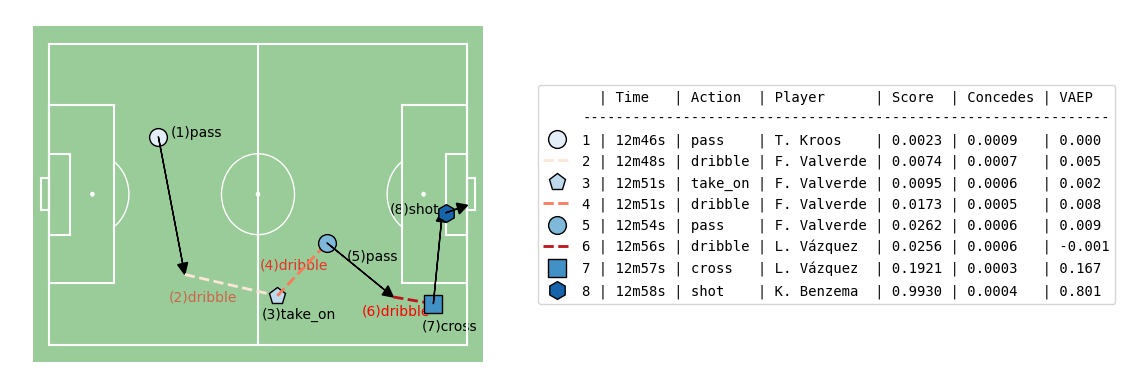

In [17]:
sorted_A = test_actions
sorted_A = sorted_A[(sorted_A.time_seconds>775.0) & (sorted_A.time_seconds<780.0)]
sorted_A = sorted_A[sorted_A.game_id==3773497]
sorted_A = sorted_A[sorted_A.team_name == "Real Madrid"]


def get_time(period_id,time_seconds):
    m = int((period_id-1)*45 + time_seconds // 60)
    s = time_seconds % 60
    if s == int(s):
        s = int(s)
    return f"{m}m{s}s"

for j in range(0, 1):
    row = list(sorted_A[j:j+1].itertuples())[0]
    i = row.Index
    a = test_actions[i - 5 : i+3].copy()
    
    
    result = False
    for vaep, team in zip(a['vaep_value'],a['team_name']):
        if (team !="Real Madrid"):
            result = True

    if result:
        continue
    
    a["player_name"] = a[["nickname", "player_name"]].apply(lambda x: x.iloc[0] if x.iloc[0] else x.iloc[1],axis=1)
    a['type_name'] = a['type_name'].replace("_"," ")
    
    for index, name in zip(a.index,a['player_name']):
        name_lst = name.split()
        first_name = name_lst[0][0] + ". "
        last_name = name_lst[-1]

        a.loc[index,'player_name'] = first_name + last_name
    
    g = list(test_games[test_games.game_id == a.game_id.values[0]].itertuples())[0]
    game_info = f"{g.game_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name}"
    minute = int((row.period_id-1)*45 + row.time_seconds // 60)

    a["scores"] = a.scores.apply(lambda x : "%.4f" % x )
    a["concedes"] = a.concedes.apply(lambda x : "%.4f" % x )
    a["vaep_value"] = a.vaep_value.apply(lambda x : "%.3f" % x )
    a["time"] = a[["period_id","time_seconds"]].apply(lambda x: get_time(*x),axis=1)

    cols = ["time", "type_name", "player_name","scores", "concedes","vaep_value"]
    t = "시간"

    matplotsoccer.actions(a[["start_x","start_y","end_x","end_y"]],
                a.type_name,
                team=a.team_name,
                result = a.result_name == "success",
                label=a[cols],
                labeltitle =  ["Time", "Action", "Player","Score", "Concedes","VAEP"],
                zoom=False,
                color="green")
   


### 아래 그림은 레알마드리드 vs 바르셀로나 경기에서 누가 가장 VAEP가 높은 이벤트를 수행했을까?

In [18]:
A = test_actions.copy()
A = A[A.game_id==3773497]

A.head()

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,...,bodypart_name,player_name,nickname,team_name,scores,concedes,offensive_value,defensive_value,vaep_value,count
32842,3773497,4bb5ef98-f35a-46a0-86d2-4300f39bdce7,1,0.0,217,5503.0,52.058824,33.655696,61.411765,37.529114,...,foot_left,Lionel Andrés Messi Cuccittini,Lionel Messi,Barcelona,0.001432,0.001580,0.000000,-0.000000,0.000000,1
32843,3773497,bfa793ab-d82a-487a-86f0-e82e477a4add,1,1.0,217,5203.0,61.411765,37.529114,60.176471,35.893671,...,foot,Sergio Busquets i Burgos,Sergio Busquets,Barcelona,0.003199,0.001108,0.001767,0.000472,0.002239,1
32844,3773497,5f18fc92-4412-47db-80fe-8bb3d78da122,1,3.0,217,5203.0,60.176471,35.893671,67.147059,23.240506,...,foot_right,Sergio Busquets i Burgos,Sergio Busquets,Barcelona,0.002594,0.000916,-0.000605,0.000192,-0.000413,1
32845,3773497,4cd38a62-7853-44a4-a53d-06c946aaa95e,1,5.0,217,6826.0,67.147059,23.240506,67.941176,22.207595,...,foot,Clément Lenglet,None,Barcelona,0.002860,0.001121,0.000266,-0.000205,0.000061,1
32846,3773497,f92ab228-1310-448b-83d0-86a44ff555a1,1,6.0,217,6826.0,67.941176,22.207595,58.764706,23.756962,...,foot_left,Clément Lenglet,None,Barcelona,0.004737,0.000869,0.001877,0.000252,0.002130,1


### 모든 이벤트를 전부 고려했을 때, VAEP의 합은 어느 선수가 가장 높을까?

- Óscar Mingueza(가르시아, 수비수)가 가장 VAEP의 합을 높게 차지함

In [19]:
A["count"] = 1

# Compute each player's number of actions and total VAEP values
playersR = (
    A[["player_id","vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)

# Add player names
playersR = playersR.merge(players[["player_id", "nickname", "player_name"]], how="left")
playersR["player_name"] = playersR[["nickname","player_name"]].apply(lambda x: x.iloc[0] if x.iloc[0] else x.iloc[1], axis=1)

# Show results
playersR = playersR[["player_id", "player_name","vaep_value", "offensive_value", "defensive_value", "count"]]
playersR['team_name'] = playersR['player_id'].apply(lambda id : player_team[id])

playersR.sort_values("vaep_value", ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,team_name
31,43728.0,Óscar Mingueza,1.391151,0.902897,0.488254,167,Barcelona
15,5574.0,Toni Kroos,1.059561,0.685748,0.373813,76,Real Madrid
12,5503.0,Lionel Messi,0.993106,1.026944,-0.033838,176,Barcelona
24,19677.0,Karim Benzema,0.982295,1.003234,-0.020940,58,Real Madrid
5,5200.0,Lucas Vázquez,0.473504,0.233751,0.239753,47,Real Madrid
9,5463.0,Luka Modrić,0.359878,0.253593,0.106285,104,Real Madrid
8,5211.0,Jordi Alba,0.271780,0.252981,0.018799,180,Barcelona
2,3804.0,Ferland Mendy,0.262549,0.091339,0.171210,53,Real Madrid
16,5719.0,Marco Asensio Willemsen,0.243057,0.233087,0.009969,22,Real Madrid
7,5203.0,Sergio Busquets,0.236600,0.147269,0.089331,164,Barcelona


### 경기를 뛴 시간대비 어느 선수가 VAEP가 가장 높을까?

- Toni Kroos는 Óscar Mingueza에 비해 적게 뛰었지만, 뛴 대비 VAEP가 높은 것을 확인할 수 있음
- 공격수/공격형미드필더(Benzema, Varzquez, Messi, Asensiom Pedri)가 랭크에 많이 띔

In [20]:
# Normalize for minutes played
pg = pd.read_hdf(test_spadl_h5, "player_games")
pg = pg[pg.game_id.isin([3773497])]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)

col = ['player_id', 'player_name', 'vaep_value', 'count', 'team_name', 'minutes_played', 'vaep_by_minutes']
stats["vaep_by_minutes"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_by_minutes"] = stats.offensive_value * 90 / stats.minutes_played
stats["defensive_by_minutes"] = stats.defensive_value * 90 / stats.minutes_played
stats.sort_values("vaep_by_minutes",ascending=False)[:10][col]

,player_id,player_name,vaep_value,count,team_name,minutes_played,vaep_by_minutes
15,5574.0,Toni Kroos,1.059561,76,Real Madrid,73,1.306308
31,43728.0,Óscar Mingueza,1.391151,167,Barcelona,96,1.304204
24,19677.0,Karim Benzema,0.982295,58,Real Madrid,73,1.211048
5,5200.0,Lucas Vázquez,0.473504,47,Real Madrid,42,1.014651
12,5503.0,Lionel Messi,0.993106,176,Barcelona,96,0.931037
16,5719.0,Marco Asensio Willemsen,0.243057,22,Real Madrid,34,0.643386
9,5463.0,Luka Modrić,0.359878,104,Real Madrid,96,0.337386
7,5203.0,Sergio Busquets,0.236600,164,Barcelona,65,0.327600
28,30486.0,Pedri,0.233101,129,Barcelona,82,0.255842
8,5211.0,Jordi Alba,0.271780,180,Barcelona,96,0.254794


### 이벤트 하나하나에 있어서 어느 선수가 VAEP가 가장 높을까?

- Karim Benzema가 매우 높은 VAEP를 갖는 것을 확인함

In [21]:
col = ['player_id', 'player_name', 'vaep_value', 'count', 'team_name', 'minutes_played', 'vaep_by_minutes','vaep_by_minutes_count']
stats["vaep_by_minutes_count"] = stats.vaep_value * 90 / stats['count']
stats["offensive_by_minutes_count"] = stats.offensive_value * 90 / stats['count']
stats["defensive_by_minutes_count"] = stats.defensive_value * 90 / stats['count']
stats.sort_values("vaep_by_minutes_count",ascending=False)[:10][col]

,player_id,player_name,vaep_value,count,team_name,minutes_played,vaep_by_minutes,vaep_by_minutes_count
24,19677.0,Karim Benzema,0.982295,58,Real Madrid,73,1.211048,1.524251
15,5574.0,Toni Kroos,1.059561,76,Real Madrid,73,1.306308,1.254743
16,5719.0,Marco Asensio Willemsen,0.243057,22,Real Madrid,34,0.643386,0.994323
5,5200.0,Lucas Vázquez,0.473504,47,Real Madrid,42,1.014651,0.906709
31,43728.0,Óscar Mingueza,1.391151,167,Barcelona,96,1.304204,0.749722
12,5503.0,Lionel Messi,0.993106,176,Barcelona,96,0.931037,0.507838
2,3804.0,Ferland Mendy,0.262549,53,Real Madrid,96,0.246139,0.445837
9,5463.0,Luka Modrić,0.359878,104,Real Madrid,96,0.337386,0.311433
27,22390.0,Francisco Trincão,0.016241,6,Barcelona,14,0.104407,0.243617
13,5539.0,Casemiro,0.202465,77,Real Madrid,91,0.200241,0.236648
